# TONG CODE

# Imports and Version Checking

In [150]:
import librosa
from librosa import display
import sklearn
import numpy as np
import torch

# for debugging
from torchsummary import summary

# python version
import sys
print("Python version: " + sys.version)

# librosa version
print("Librosa version: " + librosa.__version__)

# sklearn
print("Sklearn version: " + sklearn.__version__)

# torch
print("Torch version: " + torch.__version__)

Python version: 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
Librosa version: 0.7.1
Sklearn version: 0.21.3
Torch version: 1.0.1.post2


# Data Loading

In [165]:
# from brendan

from sklearn.model_selection import train_test_split

all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
Y_LIMIT = 660000

In [166]:
# Loads n_songs songs from each genre in load_genres.  
def load_dataset(genres=all_genres, n_songs=num_songs):
    X, Y = None, None
    for g_idx, g in enumerate(genres):
        for s_idx in range(n_songs):
            y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.au')
            # Limit length of sample so that all features have the same length.
            y = y[:Y_LIMIT]
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13).flatten()
            
            if X is None:
                X = mfcc.reshape(1, mfcc.shape[0])
                Y = np.array([[g_idx]])
                
            else:
                X = np.vstack([X, mfcc])
                Y = np.vstack([Y, np.array([[g_idx]])])
    return X, Y

In [147]:
X, Y = load_dataset(all_genres, 100)
Y = Y.ravel()

In [170]:
print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1000, 16770) (1000,)
(750, 16770) (250, 16770) (750,) (250,)


In [175]:
# making torch style dataset and dataloader

from torch.utils.data import Dataset, DataLoader

class MusicDataset(Dataset):

    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        assert(self.X.size()[0] == self.Y.size()[0])
        return self.X.size()[0]

    def __getitem__(self, index):
        data = self.X[index,].reshape((1,self.X.size()[1]))
        label = self.Y[index]
        
        return (data, label)

trainset = MusicDataset(X_train, Y_train)
testset = MusicDataset(X_test, Y_test)
print(len(trainset))
print(len(testset))

trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = DataLoader(testset, batch_size = 64, shuffle = False)

750
250


# DCNN Model

In [176]:
import torch.nn as nn
import torch.nn.functional as F
import math

class DCNN_Unit(nn.Module):
    
    def __init__(self, in_planes, planes, kernel_size, dialation, pool_size):
        
        super(DCNN_Unit, self).__init__()
        
        padding = int((kernel_size + (kernel_size - 1)*(dialation - 1) - 1)/2)
        
        self.dconv = nn.Conv1d(in_channels = in_planes, out_channels = planes,
                               kernel_size = kernel_size, stride=1, padding=padding, dilation=dialation)
        self.dropout = nn.Dropout(p=0.5)
        self.avgpool = nn.AvgPool1d(kernel_size = pool_size)
        self.bnorm = nn.BatchNorm1d(num_features = planes)
    
    def forward(self, x):
        x = self.dconv(x)
        x = self.dropout(x)
        x = self.avgpool(x)
        x = self.bnorm(x)
        x = F.relu(x)
        return x

In [185]:
class DCNN(nn.Module):
    
    def __init__(self, input_length, num_filters_1, ker_size_1, dialation_1, avg_pool_size_1,
                 num_filters_2, ker_size_2, dialation_2, avg_pool_size_2):    
        super(DCNN, self).__init__()
        self.dc_unit_1 = DCNN_Unit(1, num_filters_1, ker_size_1, dialation_1, avg_pool_size_1)
        self.dc_unit_2 = DCNN_Unit(num_filters_1, num_filters_1*num_filters_2, ker_size_2, dialation_2, avg_pool_size_2)
        in_features = num_filters_1*num_filters_2*math.floor(math.floor(input_length/avg_pool_size_1)/avg_pool_size_2)
        self.fc = nn.Linear(in_features = in_features, out_features = 10)
        
    def forward(self, x):
        x = self.dc_unit_1(x)
        x = self.dc_unit_2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

In [186]:
# Debugging
input_length = 16770

num_filters_1 = 8
ker_size_1 = 64
dialation_1 = 8
avg_pool_size_1 = 32

num_filters_2 = 64
ker_size_2 = 16
dialation_2 = 2
avg_pool_size_2 = 4

test_model = DCNN(input_length, num_filters_1, ker_size_1, dialation_1, avg_pool_size_1, num_filters_2, ker_size_2, dialation_2, avg_pool_size_2)
summary(test_model, (1,16770))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 8, 16770]             520
           Dropout-2             [-1, 8, 16770]               0
         AvgPool1d-3               [-1, 8, 524]               0
       BatchNorm1d-4               [-1, 8, 524]              16
         DCNN_Unit-5               [-1, 8, 524]               0
            Conv1d-6             [-1, 512, 524]          66,048
           Dropout-7             [-1, 512, 524]               0
         AvgPool1d-8             [-1, 512, 131]               0
       BatchNorm1d-9             [-1, 512, 131]           1,024
        DCNN_Unit-10             [-1, 512, 131]               0
           Linear-11                   [-1, 10]         670,730
Total params: 738,338
Trainable params: 738,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/

/home/tzhao/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [179]:
net = DCNN(input_length, num_filters_1, ker_size_1, dialation_1, avg_pool_size_1,
                  num_filters_2, ker_size_2, dialation_2, avg_pool_size_2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [180]:
# training and testing
def train(num_epochs):
    net.train()
    for epoch in range(num_epochs):
        print("Epoch: " + str(epoch+1))
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()            
            running_loss += loss.item()
        print("Loss: " + str(running_loss / 750.0))
    print('Finished Training')

def test():
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [187]:
train(20)

Epoch: 1
Loss: 0.013423179626464844
Epoch: 2
Loss: 0.011090693950653076
Epoch: 3
Loss: 0.010105026443799337
Epoch: 4
Loss: 0.008588590661684672
Epoch: 5
Loss: 0.008518337289492289
Epoch: 6
Loss: 0.0063229696750640866
Epoch: 7
Loss: 0.005492618441581726
Epoch: 8
Loss: 0.004389383554458618
Epoch: 9
Loss: 0.004108041087786357
Epoch: 10
Loss: 0.003591948757568995
Finished Training


In [189]:
test()

Accuracy of the network on the 10000 test images: 51 %


In [191]:
# from brendan
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title} Confusion Matrix'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

In [192]:
# test_labels = Y_test

def net_confusion_matrix(net, test_labels, title):
    
    # generating predictions
    separate_predictions = []
    
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            separate_predictions.append(predicted.numpy())
    
    predictions = np.concatenate(separate_predictions)
    plot_confusion_matrix(test_labels, predictions, title)            

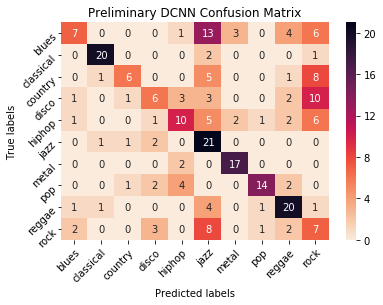

In [193]:
net_confusion_matrix(net, Y_test, "Preliminary DCNN")

TODO:

- Develop MFCCs
- Work under assumption that we are flattening MFCCs for each song
- Develop architecture for DCNN under those assumptions (13 * 1290 X 1 input data point)